In [1]:
from IPython.display import display, display_markdown
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier

## Reading data

In [2]:
training_data = pd.read_csv('training_set_values.csv', index_col=0)
training_label = pd.read_csv('training_set_labels.csv', index_col=0)

test_data = pd.read_csv('test_set_values.csv', index_col=0)

# Merge test data and training data to apply same data management operations on them
data = training_data.append(test_data).sort_index()
data.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,2012-11-13,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,0,Lake Tanganyika,...,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
1,0.0,2011-03-05,Shipo,1978,SHIPO,34.770717,-9.395642,none,0,Rufiji,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2,0.0,2011-03-27,Lvia,0,LVIA,36.115056,-6.279268,Bombani,0,Wami / Ruvu,...,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
3,10.0,2013-06-03,Germany Republi,1639,CES,37.147432,-3.187555,Area 7 Namba 5,0,Pangani,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
4,0.0,2011-03-22,Cmsr,0,CMSR,36.164893,-6.099289,Ezeleda,0,Wami / Ruvu,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump


## Data management

In [3]:
# As lots of waterpoints are missing a value for amount_tsh. For that field the missing
# data will be replaced by the mean data to drop less data for the model fit
imp = preprocessing.Imputer(missing_values=0, strategy='mean')
imp.fit(data['amount_tsh'].values.reshape(-1, 1))
data['water_amount'] = imp.transform(data['amount_tsh'].values.reshape(-1, 1)).ravel()

imp = preprocessing.Imputer(missing_values=0, strategy='median')
imp.fit(data['construction_year'].values.reshape(-1, 1))
data['construction_year'] = imp.transform(data['construction_year'].values.reshape(-1, 1)).ravel()

imp = preprocessing.Imputer(missing_values=0, strategy='mean')
imp.fit(data['gps_height'].values.reshape(-1, 1))
data['height'] = imp.transform(data['gps_height'].values.reshape(-1, 1)).ravel()

# Recode missing data as NaN
for field in ('longitude', 'latitude'):
    data[field] = data[field].map(lambda x: x if x else pd.np.nan)

def group_installer(data):
    def gather_installer(x):
        installer_map = {
            'organisation' : ('bank', 'msf', 'wwf', 'unicef', 'unisef', 'oxfam', 'oxfarm', 'club', 'care', 'without', 'faim', 'rain', 'red', 'angels', 'fundat', 'foundation'),
            'church' : ('church', 'churc', 'rcchurch', 'roman', 'missionsry', 'lutheran', 'islamic', 'islam', 'vision'),
            'private' : ('consulting', 'engineer', 'private', 'ltd', 'co.ltd', 'contractor', 'enterp', 'enterpr', 'company', 'contract'),
            'community' : ('village', 'community', 'communit', 'district', 'council', 'commu', 'villigers', 'villagers'),
            'government' : ('government', 'gov', 'govt', 'gover', 'gove', 'governme', 'ministry'),
            'other' : ('0', 'nan', 'known', 'other', 'unknown'), # Group 'unknown' data with 'other' as finally this means the same for interpretation
            'danida' : ('danida', 'danid'),
            'foreign government' : ('netherlands', 'germany', 'european')
        }

        for substr in x.split():
            for subsubstr in substr.split('/'):
                for key in installer_map:
                    if subsubstr in installer_map[key]:
                        return key

        return x
    
    lower_data = data.map(lambda x: str(x).lower())
    tmp_data = lower_data.map(gather_installer)
    top10 = list(tmp_data.value_counts()[:10].index)
    
    return tmp_data.map(lambda x: x if x in top10 else 'other')

data['installer'] = group_installer(data.installer)
data['funder'] = group_installer(data.funder)

clean_data = (data.iloc[training_data.index]
                  .join(training_label['status_group'])
                  .dropna())
# Create two columns one collapsing 'functional' and 'functional needs repair'
# and the other one collapsing 'non functional' and 'functional needs repair'
clean_data['functional'] = clean_data['status_group'].map({'functional' : 1, 
                                                           'functional needs repair' : 1,
                                                           'non functional' : 0})
clean_data['no_repairs'] = clean_data['status_group'].map({'functional' : 1, 
                                                           'functional needs repair' : 0,
                                                           'non functional' : 0})

In [21]:
# Extract predictors and convert categorical variables in dichotomic variables
predictors_name = ['water_amount', 'height', 'longitude', 'latitude',
                   'basin', 'region', 'population', 'public_meeting', 'management_group',
                   'permit', 'construction_year', 'extraction_type_class', 'payment_type',
                   'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group',
                   'installer', 'funder']

categorical_predictors = ('basin', 'region', 'management_group', 'extraction_type_class', 
                          'payment_type', 'quality_group', 'quantity_group', 
                          'source_type', 'waterpoint_type_group', 'installer', 'funder')

process_data = pd.DataFrame()
for name in predictors_name:
    if name in categorical_predictors:
        classes = data[name].unique()
        deployed_categories = preprocessing.label_binarize(data[name], classes=classes)
        # Avoid class name collision
        classe_names = list()
        for c in classes:
            if c in process_data.columns or c == 'other':
                classe_names.append('_'.join((c, name)))
            else:
                classe_names.append(c)
        
        tmp_df = pd.DataFrame(deployed_categories, 
                              columns=classe_names, 
                              index=data.index)
        process_data = process_data.join(tmp_df)
    else:
        process_data[name] = data[name]

predictors_columns = process_data.columns
        
deployed_data = (process_data.iloc[training_data.index]
                             .join(training_label['status_group'])
                             .dropna())
# Create two columns one collapsing 'functional' and 'functional needs repair'
# and the other one collapsing 'non functional' and 'functional needs repair'
deployed_data['functional'] = deployed_data['status_group'].map({'functional' : 1, 
                                                                 'functional needs repair' : 1,
                                                                 'non functional' : 0})
deployed_data['no_repairs'] = deployed_data['status_group'].map({'functional' : 1, 
                                                                 'functional needs repair' : 0,
                                                                 'non functional' : 0})

predictors = deployed_data[predictors_columns]

In [22]:
# fit an Extra Trees model to the data and look at the first 15 important fields
model = ExtraTreesClassifier()
model.fit(predictors, deployed_data['status_group'])
# display the relative importance of each attribute
cm = sns.light_palette("yellow", as_cmap=True)
(pd.Series(model.feature_importances_, index=predictors.columns, name='importance')
   .sort_values(ascending=False)
   .to_frame()
   .iloc[:15])

,importance
longitude,0.215015
latitude,0.213995
height,0.102522
dry,0.087070
construction_year,0.081414
population,0.069988
enough,0.028758
other_waterpoint_type_group,0.027214
other_extraction_type_class,0.026204
never pay,0.018179


In [8]:
data.shape

(74250, 41)

In [23]:
# Extract predictors and convert categorical variables in dichotomic variables
# predictors_name = ['water_amount', 'height', 'longitude', 'latitude',
#                    'basin', 'region', 'population', 'public_meeting', 'management_group',
#                    'permit', 'construction_year', 'extraction_type_class', 'payment_type',
#                    'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group',
#                    'installer', 'funder']

# categorical_predictors = ('basin', 'region', 'management_group', 'extraction_type_class', 
#                           'payment_type', 'quality_group', 'quantity_group', 
#                           'source_type', 'waterpoint_type_group', 'installer', 'funder')

predictors_name = ['height', 'longitude', 'latitude', 'population',
                   'permit', 'construction_year', 'extraction_type_class', 'payment_type',
                   'quantity_group', 'waterpoint_type_group']

categorical_predictors = ('extraction_type_class', 'payment_type', 'quantity_group', 
                          'waterpoint_type_group')

process_data = pd.DataFrame()
for name in predictors_name:
    if name in categorical_predictors:
        classes = data[name].unique()
        deployed_categories = preprocessing.label_binarize(data[name], classes=classes)
        # Avoid class name collision
        classe_names = list()
        for c in classes:
            if c in process_data.columns:
                classe_names.append('_'.join((c, name)))
            else:
                classe_names.append(c)
        
        tmp_df = pd.DataFrame(deployed_categories, 
                              columns=classe_names, 
                              index=data.index)
        process_data = process_data.join(tmp_df)
    else:
        process_data[name] = data[name]

predictors_columns = process_data.columns
        
deployed_data = (process_data.iloc[training_data.index]
                             .join(training_label['status_group'])
                             .dropna())
# Create two columns one collapsing 'functional' and 'functional needs repair'
# and the other one collapsing 'non functional' and 'functional needs repair'
deployed_data['functional'] = deployed_data['status_group'].map({'functional' : 1, 
                                                                 'functional needs repair' : 1,
                                                                 'non functional' : 0})
deployed_data['no_repairs'] = deployed_data['status_group'].map({'functional' : 1, 
                                                                 'functional needs repair' : 0,
                                                                 'non functional' : 0})

predictors = deployed_data[predictors_columns]

## Explanatory variables selection

As there are a lot of potential explanatory variable, so let's focus of those having a real influence by using a Random Forest test.

In [24]:
# fit an Extra Trees model to the data and look at the first 20 important fields
model = ExtraTreesClassifier()
model.fit(predictors, deployed_data['status_group'])
# display the relative importance of each attribute
cm = sns.light_palette("yellow", as_cmap=True)
(pd.Series(model.feature_importances_, index=predictors.columns, name='importance')
   .sort_values(ascending=False)
   .to_frame()
   .iloc[:20]
   .style.background_gradient(cmap=cm))

# Univariate distribution

In this section the frequencies tables for all categorical variables and the distribution for all quantitative variables will be presented. The missing data will be dropped.

## Categorical variables distribution

### Status group distribution

status_group,functional,non functional,functional needs repair
unnormalized,32259.000000,22824.000000,4317.000000
normalized,0.543081,0.384242,0.072677


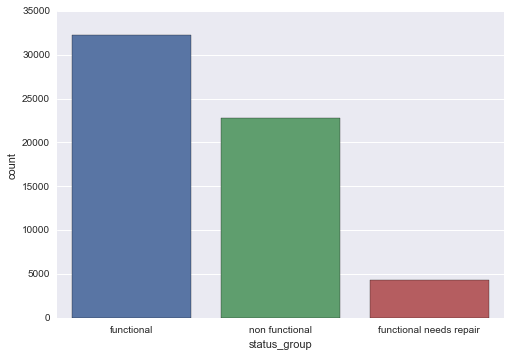

In [25]:
# Visualize status only for the training set
field = 'status_group'
display_markdown("### {} distribution".format(' '.join(field.split('_')).capitalize()), 
                 raw=True)
tmp_df = training_label[field].value_counts(dropna=False)
tmp_df.index.name = tmp_df.name
tmp_df.name = 'unnormalized'
tmp_df2 = training_label[field].value_counts(dropna=False, normalize=True)
tmp_df2.name = 'normalized'
tmp_df = tmp_df.to_frame().join(tmp_df2)
display(tmp_df.T)
fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.countplot(field, data=training_label, ax=ax)
lbls = ax.get_xticklabels()
if len(lbls) > 7:
    ax.set_xticklabels(lbls, rotation=90)
plt.show()

### Extraction type class distribution

extraction_type_class,gravity,handpump,other,submersible,motorpump,rope pump,wind-powered
unnormalized,33263.000000,20612.000000,8102.000000,7772.000000,3777.000000,572.000000,152.000000
normalized,0.447987,0.277603,0.109118,0.104673,0.050869,0.007704,0.002047


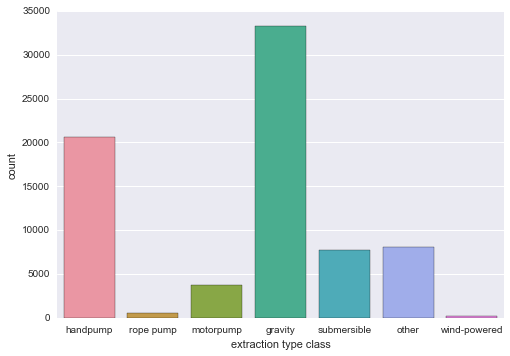

### Payment type distribution

payment_type,never pay,per bucket,monthly,unknown,on failure,annually,other
unnormalized,31712.000000,11266.000000,10397.000000,10149.000000,4842.000000,4570.000000,1314.000000
normalized,0.427098,0.151731,0.140027,0.136687,0.065212,0.061549,0.017697


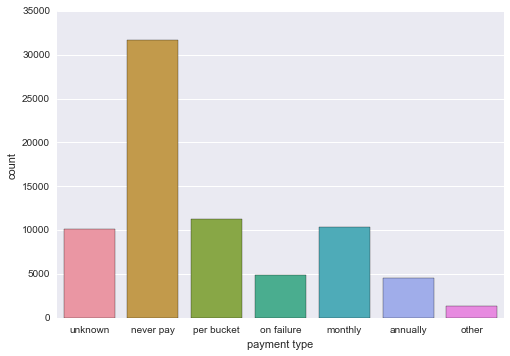

### Quantity group distribution

quantity_group,enough,insufficient,dry,seasonal,unknown
unnormalized,41522.000000,18896.000000,7782.000000,5075.00000,975.000000
normalized,0.559219,0.254492,0.104808,0.06835,0.013131


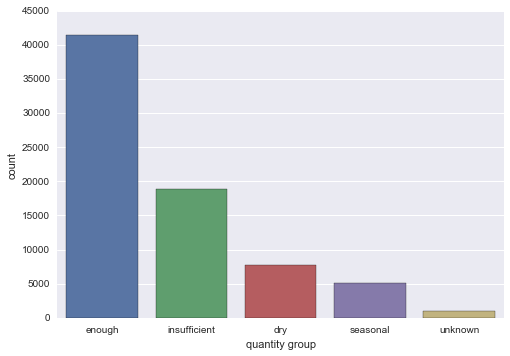

### Waterpoint type group distribution

waterpoint_type_group,communal standpipe,hand pump,other,improved spring,cattle trough,dam
unnormalized,43239.000000,21884.000000,8010.000000,959.000000,150.00000,8.000000
normalized,0.582343,0.294734,0.107879,0.012916,0.00202,0.000108


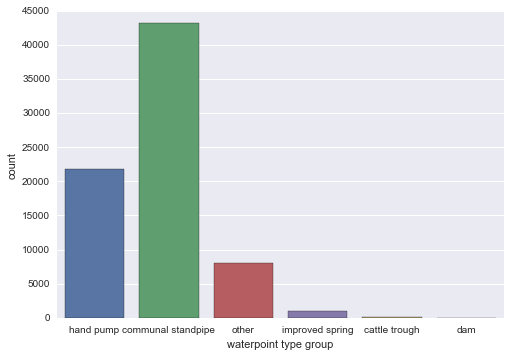

### Public meeting distribution

public_meeting,True,False,nan
unnormalized,63749.000000,6346.000000,4155.00000
normalized,0.858572,0.085468,0.05596


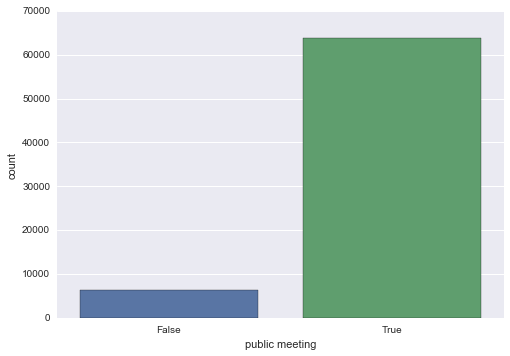

### Permit distribution

permit,True,False,nan
unnormalized,48606.000000,21851.00000,3793.000000
normalized,0.654626,0.29429,0.051084


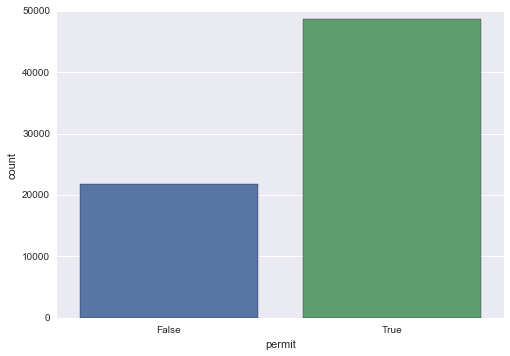

In [26]:
pd.set_option('display.max_columns', 25)
list_fields = list(categorical_predictors)
list_fields.extend(('public_meeting', 'permit'))
for field in list_fields:
    field_name = ' '.join(field.split('_'))
    display_markdown("### {} distribution".format(field_name.capitalize()), 
                     raw=True)
    tmp_df = data[field].value_counts(dropna=False)
    tmp_df.index.name = tmp_df.name
    tmp_df.name = 'unnormalized'
    tmp_df2 = data[field].value_counts(dropna=False, normalize=True)
    tmp_df2.name = 'normalized'
    tmp_df = tmp_df.to_frame().join(tmp_df2)
#     display(data[field].value_counts(dropna=False).to_frame().T)
    display(tmp_df.T)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.countplot(field, data=data, ax=ax)
    lbls = ax.get_xticklabels()
    if len(lbls) > 7:
        ax.set_xticklabels(lbls, rotation=90)
    ax.set_xlabel(field_name)
    plt.show()

## Quantitative variable distribution

### Gps height distribution

,count,mean,std,min,25%,50%,75%,max
gps_height,38962.0,1018.860839,612.566092,-90.0,393.0,1167.0,1498.0,2770.0


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


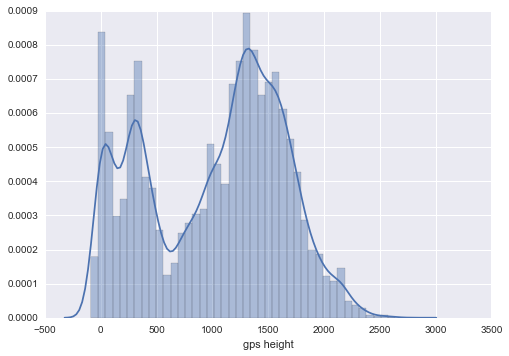

### Latitude distribution

,count,mean,std,min,25%,50%,75%,max
latitude,59400.0,-5.706033,2.946019,-11.64944,-8.540621,-5.021597,-3.326156,-2.000000e-08


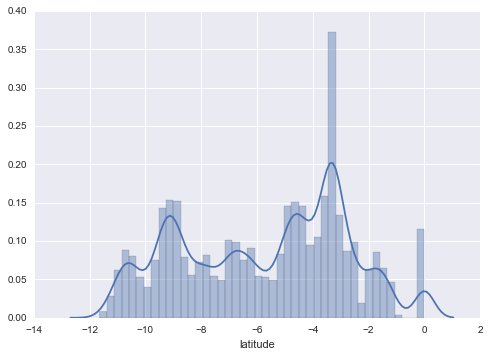

### Longitude distribution

,count,mean,std,min,25%,50%,75%,max
longitude,57588.0,35.149669,2.607428,29.607122,33.2851,35.005943,37.233712,40.345193


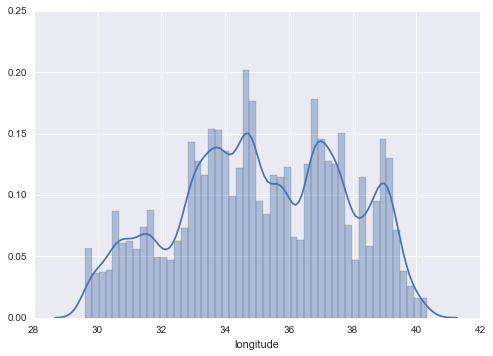

### Construction year distribution

,count,mean,std,min,25%,50%,75%,max
construction_year,38691.0,1996.814686,12.472045,1960.0,1987.0,2000.0,2008.0,2013.0


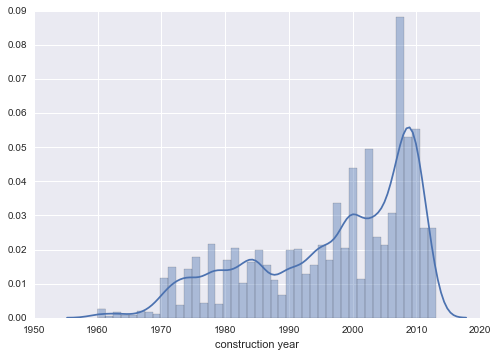

### Population distribution

,count,mean,std,min,25%,50%,75%,max
population,38019.0,281.087167,564.68766,1.0,40.0,150.0,324.0,30500.0


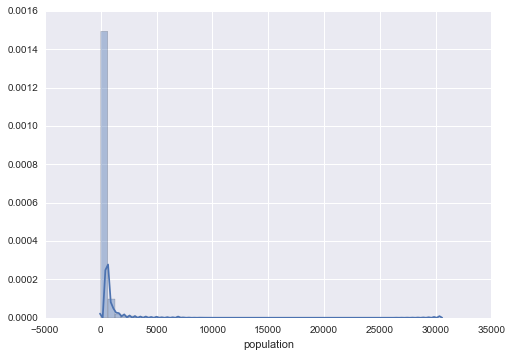

In [27]:
# for field in ('amount_tsh', 'gps_height', 'latitude', 'longitude', 'construction_year', 'population'):
for field in ('gps_height', 'latitude', 'longitude', 'construction_year', 'population'):
    field_name = ' '.join(field.split('_'))
    display_markdown("### {} distribution".format(field_name.capitalize()), 
                     raw=True)
    clean_field = training_data[field].map(lambda x: x if abs(x)>1e-8 else pd.np.nan)
    clean_field = clean_field.dropna()
    display(clean_field.describe().to_frame().T)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.distplot(clean_field)
    ax.set_xlabel(field_name)
    plt.show()

# Bivariate distribution

If the response variable is categorical with more than two categories, it is adviced to collapse the categories into two categories. So for presenting the bivariate distribution, the *functional* and *functional needs repair* categories will be collapsed. Then the distribution for the data falling in that new category will depicted.

The distribution will be presented using bar chart. For quantitative explanatory variables, the data will be collapsed in two categories defined by the median.

Along with the visualization, hypothesis testing will be carried out. As the response variable is categorical, the method will be the chi-square test.

### Extraction type class

Contingency table of observed counts

extraction_type_class,gravity,handpump,motorpump,other,rope pump,submersible,wind-powered
status_group,,,,,,,
functional,12094,804,752,185,7,2061,30
functional needs repair,1709,21,85,12,0,174,5
non functional,5786,422,1031,637,20,1651,35


extraction_type_class,gravity,handpump,motorpump,other,rope pump,submersible,wind-powered
status_group,,,,,,,
functional,0.617387,0.644747,0.402570,0.221823,0.259259,0.530365,0.428571
functional needs repair,0.087243,0.016840,0.045503,0.014388,0.000000,0.044776,0.071429
non functional,0.295370,0.338412,0.551927,0.763789,0.740741,0.424858,0.500000


There is a significant relationship between extraction type class and the functional status of the waterpoint (p-value = 3.5e-287).

There is a significant relationship between extraction type class and the no repairs status of the waterpoint (p-value = 6.8e-185).

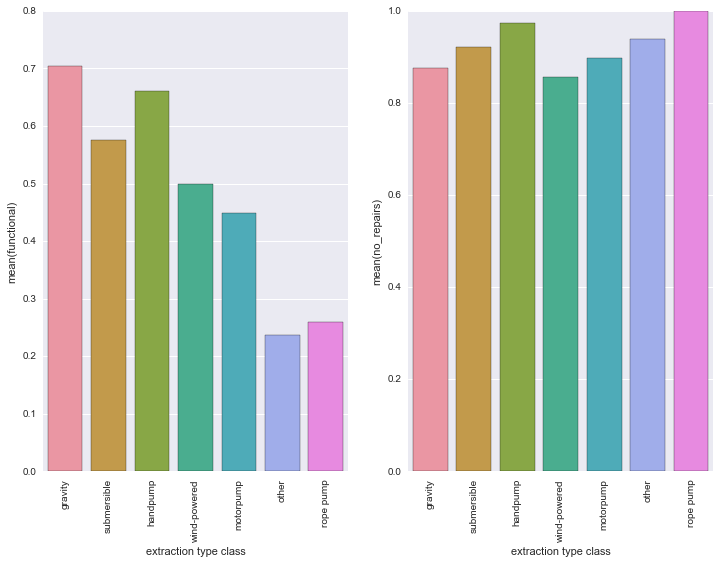

Test again *functional* status

p-value     Ha
gravity      handpump       1.420607e-03   True
             motorpump     2.262516e-114   True
             other         1.346001e-178   True
             rope pump      1.202484e-06   True
             submersible    1.910445e-56   True
             wind-powered   3.034969e-04   True
handpump     motorpump      1.873751e-31   True
             other          2.637283e-80   True
             rope pump      3.460225e-05   True
             wind-powered   8.423967e-03  False
motorpump    other          1.930282e-25   True
             rope pump      7.757985e-02  False
other        rope pump      9.622983e-01  False
submersible  handpump       7.446052e-08   True
             motorpump      1.895132e-19   True
             other          2.349516e-70   True
             rope pump      1.860833e-03   True
             wind-powered   2.550959e-01  False
wind-powered motorpump      4.623263e-01  False
             other          2.465892e-06   True
             rope pump      5.535722e-02  False

Test again *no repairs* status

p-value     Ha
gravity      handpump       5.756493e-02  False
             motorpump      5.142137e-73   True
             other         3.419231e-115   True
             rope pump      2.865684e-04   True
             submersible    4.982951e-24   True
             wind-powered   1.806478e-03   True
handpump     motorpump      7.827683e-40   True
             other          1.441784e-79   True
             rope pump      8.932081e-05   True
             wind-powered   4.242535e-04   True
motorpump    other          1.135053e-19   True
             rope pump      1.898417e-01  False
other        rope pump      8.219331e-01  False
submersible  handpump       1.866009e-12   True
             motorpump      1.399579e-19   True
             other          1.123694e-58   True
             rope pump      8.823464e-03  False
             wind-powered   1.163752e-01  False
wind-powered motorpump      7.555927e-01  False
             other          1.724771e-04   True
             rope pump      1.917519e-01  False

### Payment type

Contingency table of observed counts

payment_type,annually,monthly,never pay,on failure,other,per bucket,unknown
status_group,,,,,,,
functional,1811,3871,4247,839,132,4188,845
functional needs repair,143,725,647,85,4,263,139
non functional,303,1276,4983,279,70,1672,999


payment_type,annually,monthly,never pay,on failure,other,per bucket,unknown
status_group,,,,,,,
functional,0.802393,0.659230,0.429989,0.697423,0.640777,0.683978,0.426122
functional needs repair,0.063358,0.123467,0.065506,0.070657,0.019417,0.042953,0.070096
non functional,0.134249,0.217302,0.504505,0.231920,0.339806,0.273069,0.503782


There is a significant relationship between payment type and the functional status of the waterpoint (p-value = 0).

There is a significant relationship between payment type and the no repairs status of the waterpoint (p-value = 0).

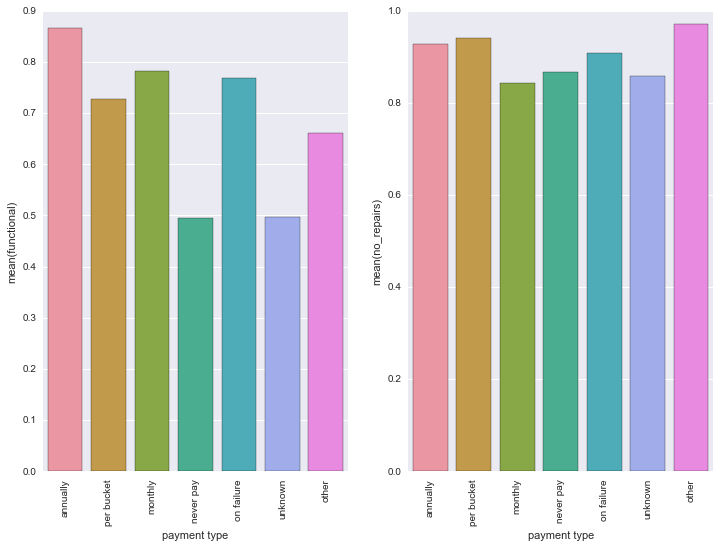

Test again *functional* status

p-value     Ha
annually   monthly      3.031849e-17   True
           never pay   1.884291e-224   True
           on failure   3.676184e-13   True
           other        7.435575e-15   True
           per bucket   4.310055e-40   True
           unknown     5.772155e-149   True
monthly    never pay   1.485108e-277   True
           on failure   2.813915e-01  False
           other        4.567542e-05   True
           unknown     2.589152e-130   True
never pay  on failure   3.172208e-71   True
           other        4.049234e-06   True
           unknown      9.727352e-01  False
on failure other        1.250186e-03   True
           unknown      8.742551e-52   True
per bucket monthly      1.547396e-12   True
           never pay   4.792608e-183   True
           on failure   3.544198e-03  False
           other        4.234480e-02  False
           unknown      3.052523e-80   True
unknown    other        1.043067e-05   True

Test again *no repairs* status

p-value     Ha
annually   monthly      2.898930e-36   True
           never pay   2.592424e-223   True
           on failure   5.118962e-12   True
           other        8.707763e-08   True
           per bucket   2.046482e-26   True
           unknown     1.496984e-140   True
monthly    never pay   2.505928e-170   True
           on failure   1.157905e-02  False
           other        6.353067e-01  False
           unknown      8.785655e-75   True
never pay  on failure   6.614117e-69   True
           other        2.372608e-09   True
           unknown      7.698215e-01  False
on failure other        1.231580e-01  False
           unknown      8.679468e-50   True
per bucket monthly      4.153706e-03  False
           never pay   1.602440e-214   True
           on failure   3.763071e-01  False
           other        2.171448e-01  False
           unknown      8.859334e-94   True
unknown    other        5.707291e-09   True

### Quantity group

Contingency table of observed counts

quantity_group,dry,enough,insufficient,seasonal,unknown
status_group,,,,,
functional,67,11722,3514,599,31
functional needs repair,5,1289,629,83,0
non functional,2701,3850,2729,207,95


quantity_group,dry,enough,insufficient,seasonal,unknown
status_group,,,,,
functional,0.024162,0.695214,0.511350,0.673791,0.246032
functional needs repair,0.001803,0.076449,0.091531,0.093363,0.000000
non functional,0.974035,0.228338,0.397119,0.232846,0.753968


There is a significant relationship between quantity group and the functional status of the waterpoint (p-value = 0).

There is a significant relationship between quantity group and the no repairs status of the waterpoint (p-value = 0).

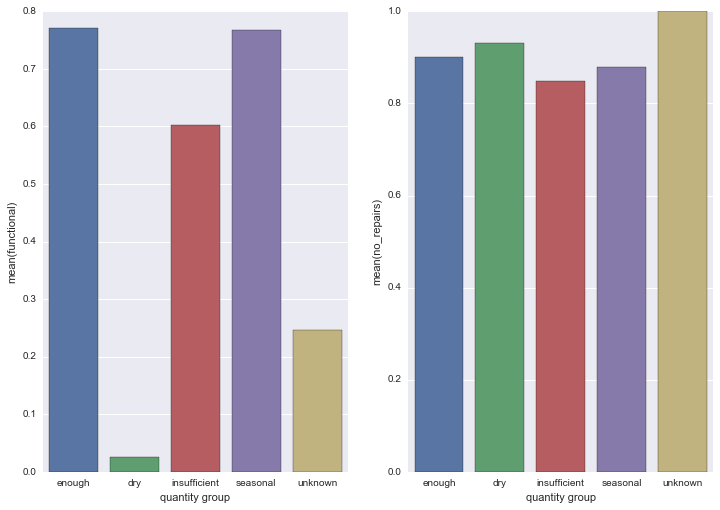

Test again *functional* status

p-value     Ha
dry          insufficient   0.000000e+00   True
             seasonal       0.000000e+00   True
             unknown        1.532922e-37   True
enough       dry            0.000000e+00   True
             insufficient  8.609560e-153   True
             seasonal       7.863726e-01  False
             unknown        2.066209e-43   True
insufficient seasonal       2.882668e-21   True
             unknown        1.252727e-15   True
seasonal     unknown        1.684947e-32   True

Test again *no repairs* status

p-value     Ha
dry          insufficient   0.000000e+00   True
             seasonal       0.000000e+00   True
             unknown        6.241413e-40   True
enough       dry            0.000000e+00   True
             insufficient  5.223492e-158   True
             seasonal       1.889251e-01  False
             unknown        4.148094e-27   True
insufficient seasonal       9.396423e-20   True
             unknown        6.131721e-09   True
seasonal     unknown        5.041900e-20   True

### Waterpoint type group

Contingency table of observed counts

waterpoint_type_group,cattle trough,communal standpipe,dam,hand pump,improved spring,other
status_group,,,,,,
functional,54,14804,5,828,57,185
functional needs repair,2,1872,0,26,8,98
non functional,8,8241,0,425,12,896


waterpoint_type_group,cattle trough,communal standpipe,dam,hand pump,improved spring,other
status_group,,,,,,
functional,0.84375,0.594133,1.0,0.647381,0.740260,0.156913
functional needs repair,0.03125,0.075129,0.0,0.020328,0.103896,0.083121
non functional,0.12500,0.330738,0.0,0.332291,0.155844,0.759966


There is a significant relationship between waterpoint type group and the functional status of the waterpoint (p-value = 4.8e-202).

There is a significant relationship between waterpoint type group and the no repairs status of the waterpoint (p-value = 6.3e-201).

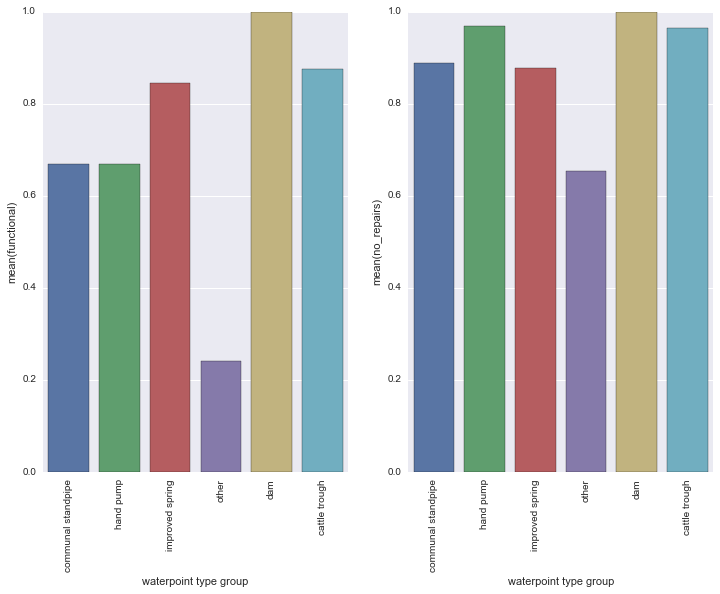

Test again *functional* status

p-value     Ha
communal standpipe cattle trough     7.731873e-04   True
                   dam               2.728643e-01  False
                   hand pump         9.325450e-01  False
                   improved spring   1.707226e-03   True
                   other            7.982696e-200   True
dam                cattle trough     9.079602e-01  False
hand pump          cattle trough     8.829528e-04   True
                   dam               2.714208e-01  False
                   improved spring   1.988047e-03   True
                   other            8.597211e-100   True
improved spring    cattle trough     7.792963e-01  False
                   dam               7.622363e-01  False
                   other             7.892635e-30   True
other              cattle trough     5.677582e-28   True
                   dam               6.033031e-04   True

Test again *no repairs* status

p-value     Ha
communal standpipe cattle trough     8.322043e-05   True
                   dam               1.637409e-01  False
                   hand pump         1.720922e-04   True
                   improved spring   1.272357e-02  False
                   other            4.682013e-193   True
dam                cattle trough     7.669887e-01  False
hand pump          cattle trough     1.974827e-03   True
                   dam               2.383203e-01  False
                   improved spring   1.237518e-01  False
                   other            4.761713e-134   True
improved spring    cattle trough     1.976478e-01  False
                   dam               4.393768e-01  False
                   other             1.898473e-35   True
other              cattle trough     4.857037e-41   True
                   dam               6.337283e-06   True

### Permit

Contingency table of observed counts

permit,False,True
status_group,,
functional,3114,12819
functional needs repair,413,1593
non functional,2426,7156


permit,False,True
status_group,,
functional,0.523098,0.594353
functional needs repair,0.069377,0.073859
non functional,0.407526,0.331788


There is a significant relationship between permit and the functional status of the waterpoint (p-value = 1.4e-26).

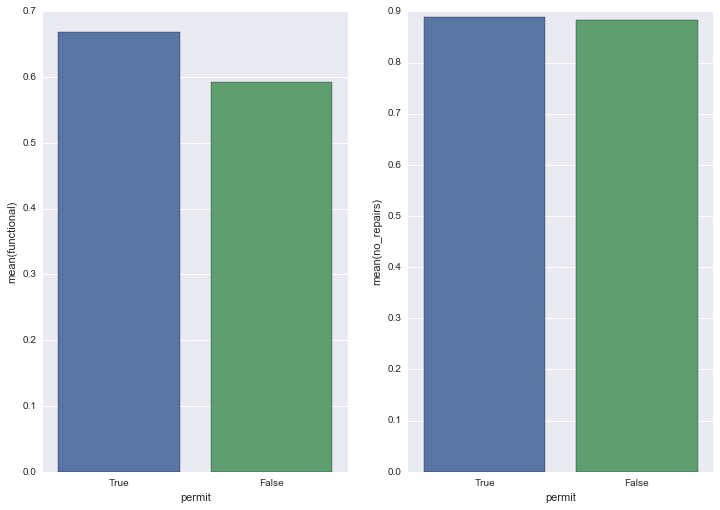

In [43]:
list_fields = list(categorical_predictors)
# list_fields.extend(('public_meeting', 'permit'))
list_fields.extend(('permit', ))
for field in list_fields:
    field_name = ' '.join(field.split('_'))
    display_markdown("### {}".format(field_name.capitalize()), 
                     raw=True)
    var_analysis = clean_data[['status_group', 'functional', 'no_repairs', field]]
        
    if len(var_analysis[field].unique()) > 2:
        # Chi-square test
        display_markdown("Contingency table of observed counts", raw=True)
        ct = pd.crosstab(var_analysis['status_group'], var_analysis[field])
        display(ct)
        ct_norm = ct/ct.sum(axis=0)
        display(ct_norm)
        
        
        ct = pd.crosstab(var_analysis['functional'], var_analysis[field])
        chisqr = stats.chi2_contingency(ct)
        
        if chisqr[1] > 0.05:
            display_markdown("There is *no* significant relationship between {} and the functional"
                             " status of the waterpoint (p-value = {:.2g}).".format(field_name, chisqr[1]),
                             raw=True)
        else:
            display_markdown("There is a significant relationship between {} and the functional"
                             " status of the waterpoint (p-value = {:.2g}).".format(field_name, chisqr[1]),
                             raw=True)
            
        ct = pd.crosstab(var_analysis['no_repairs'], var_analysis[field])
        chisqr = stats.chi2_contingency(ct)
        
        if chisqr[1] > 0.05:
            display_markdown("There is *no* significant relationship between {} and the no repairs"
                             " status of the waterpoint (p-value = {:.2g}).".format(field_name, chisqr[1]),
                             raw=True)
        else:
            display_markdown("There is a significant relationship between {} and the no repairs"
                             " status of the waterpoint (p-value = {:.2g}).".format(field_name, chisqr[1]),
                             raw=True)
        
        fig = plt.figure(figsize=[1.5*l for l in plt.rcParams['figure.figsize']])
        ax = fig.add_subplot(121)
        ax = sns.barplot(x=field, y='functional', data=var_analysis, ci=None, ax=ax)
        ax.set_xlabel(field_name)
        lbls = ax.get_xticklabels()
        if len(lbls) > 5:
            ax.set_xticklabels(lbls, rotation=90)
        ax = fig.add_subplot(122)
        ax = sns.barplot(x=field, 
                         y='no_repairs', 
                         data=var_analysis.where(var_analysis['functional'] == 1),
                         ci=None,
                         ax=ax,
                         order=[l.get_text() for l in lbls])
        ax.set_xlabel(field_name)
        lbls = ax.get_xticklabels()
        if len(lbls) > 5:
            ax.set_xticklabels(lbls, rotation=90)
        plt.show()
        
        display_markdown("Test again *functional* status", raw=True)
        categories = var_analysis[field].unique()
        list_field = list(categories)
        p_values = dict()
        for i in range(len(list_field)):
            for j in range(i+1, len(list_field)):
                cat1 = list_field[i]
                cat2 = list_field[j]
                explanatory = var_analysis[field].map(dict(((cat1, cat1),
                                                            (cat2, cat2))))
                comparison = pd.crosstab(var_analysis['functional'], explanatory)
#                 display(Markdown("Crosstable to compare {} and {}".format(cat1, cat2)))
#                 display(comparison)
#                 display(comparison/comparison.sum(axis=0))

                chi_square, p, _, expected_counts = stats.chi2_contingency(comparison)
                p_values[(cat1, cat2)] = p
        df = pd.DataFrame(p_values, index=['p-value', ])

        display(df.stack(level=[0, 1])['p-value']
                  .rename('p-value')
                  .to_frame()
                  .assign(Ha=lambda x: x['p-value'] < 0.05 / len(p_values)))
        
        display_markdown("Test again *no repairs* status", raw=True)
        categories = var_analysis[field].unique()
        list_field = list(categories)
        p_values = dict()
        for i in range(len(list_field)):
            for j in range(i+1, len(list_field)):
                cat1 = list_field[i]
                cat2 = list_field[j]
                explanatory = var_analysis[field].map(dict(((cat1, cat1),
                                                            (cat2, cat2))))
                comparison = pd.crosstab(var_analysis['no_repairs'], explanatory)
#                 display(Markdown("Crosstable to compare {} and {}".format(cat1, cat2)))
#                 display(comparison)
#                 display(comparison/comparison.sum(axis=0))

                chi_square, p, _, expected_counts = stats.chi2_contingency(comparison)
                p_values[(cat1, cat2)] = p
        df = pd.DataFrame(p_values, index=['p-value', ])

        display(df.stack(level=[0, 1])['p-value']
                  .rename('p-value')
                  .to_frame()
                  .assign(Ha=lambda x: x['p-value'] < 0.05 / len(p_values)))
        
    else:
        # Chi-square test
        display_markdown("Contingency table of observed counts", raw=True)
        ct = pd.crosstab(var_analysis['status_group'], var_analysis[field])
        display(ct)
        ct_norm = ct/ct.sum(axis=0)
        display(ct_norm)
        
        chisqr = stats.chi2_contingency(ct)
        
        if chisqr[1] > 0.05:
            display_markdown("There is *no* significant relationship between {} and the functional"
                             " status of the waterpoint (p-value = {:.2g}).".format(field_name, chisqr[1]),
                             raw=True)
        else:
            display_markdown("There is a significant relationship between {} and the functional"
                             " status of the waterpoint (p-value = {:.2g}).".format(field_name, chisqr[1]),
                             raw=True)
        
        fig = plt.figure(figsize=[1.5*l for l in plt.rcParams['figure.figsize']])
        ax = fig.add_subplot(121)
        ax = sns.barplot(x=field, y='functional', data=var_analysis, ci=None, ax=ax,
                         order=[True, False])
        ax.set_xlabel(field_name)
        lbls = ax.get_xticklabels()
        if len(lbls) > 5:
            ax.set_xticklabels(lbls, rotation=90)
        ax = fig.add_subplot(122)
        ax = sns.barplot(x=field, 
                         y='no_repairs', 
                         data=var_analysis.where(var_analysis['functional'] == 1),
                         ci=None,
                         ax=ax,
                         order=[True, False])
        ax.set_xlabel(field_name)
        lbls = ax.get_xticklabels()
        if len(lbls) > 5:
            ax.set_xticklabels(lbls, rotation=90)
        plt.show()

### Gps height

Contingency table of observed counts

gps_heightgrp4,1=50th%tile,2=100th%tile
status_group,,
functional,5958,7397
functional needs repair,981,633
non functional,4013,2909


gps_heightgrp4,1=50th%tile,2=100th%tile
status_group,,
functional,0.544010,0.676204
functional needs repair,0.089573,0.057866
non functional,0.366417,0.265929


There is a significant relationship between gps height and the functional status of the waterpoint (p-value = 2e-57).

There is a significant relationship between gps height and the no repair status of the waterpoint (p-value = 2.6e-89).

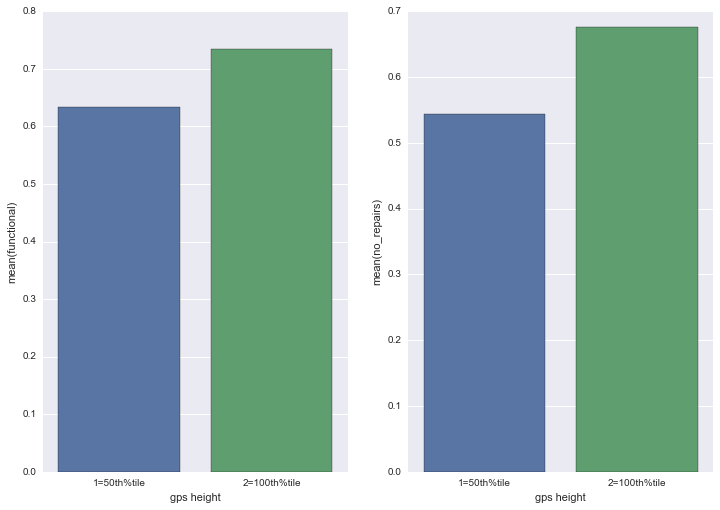

### Latitude

Contingency table of observed counts

latitudegrp4,1=50th%tile,2=100th%tile
status_group,,
functional,8137,7796
functional needs repair,728,1278
non functional,4896,4686


latitudegrp4,1=50th%tile,2=100th%tile
status_group,,
functional,0.591309,0.566570
functional needs repair,0.052903,0.092878
non functional,0.355788,0.340552


There is a significant relationship between latitude and the functional status of the waterpoint (p-value = 0.0083).

There is a significant relationship between latitude and the no repair status of the waterpoint (p-value = 3.4e-05).

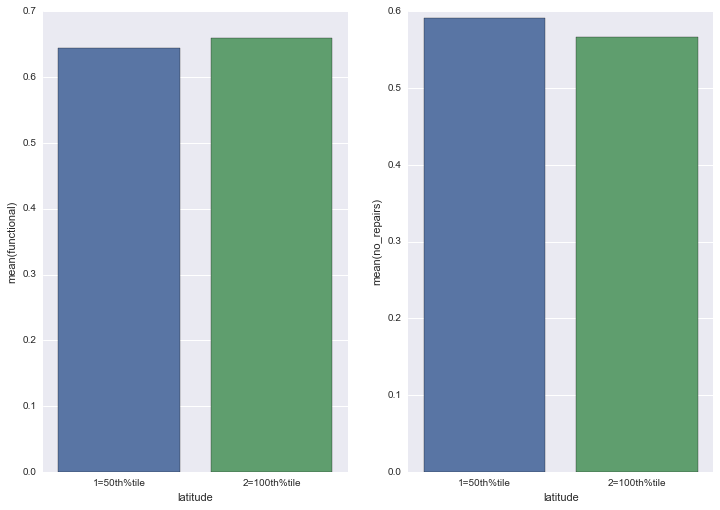

### Longitude

Contingency table of observed counts

longitudegrp4,1=50th%tile,2=100th%tile
status_group,,
functional,8007,7926
functional needs repair,1079,927
non functional,4675,4907


longitudegrp4,1=50th%tile,2=100th%tile
status_group,,
functional,0.581862,0.576017
functional needs repair,0.078410,0.067369
non functional,0.339728,0.356613


There is a significant relationship between longitude and the functional status of the waterpoint (p-value = 0.0034).

There is *no* significant relationship between longitude and the no repair status of the waterpoint (p-value = 0.33).

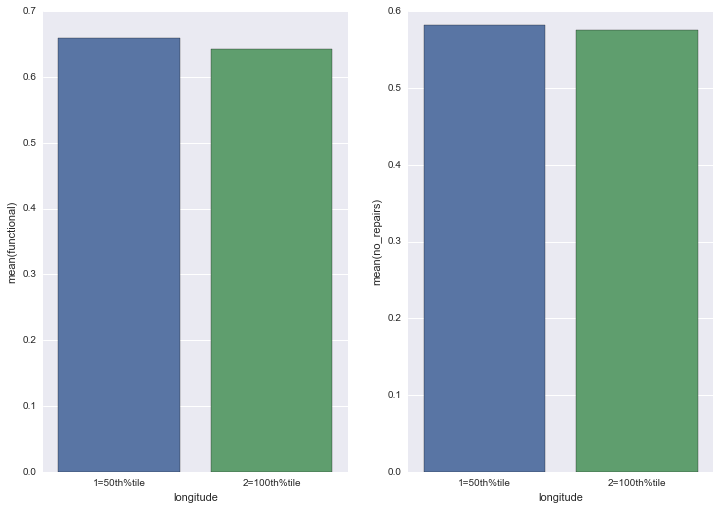

### Construction year

Contingency table of observed counts

construction_yeargrp4,1=50th%tile,2=100th%tile
status_group,,
functional,8259,7674
functional needs repair,1326,680
non functional,7328,2254


construction_yeargrp4,1=50th%tile,2=100th%tile
status_group,,
functional,0.488323,0.723416
functional needs repair,0.078401,0.064103
non functional,0.433276,0.212481


There is a significant relationship between construction year and the functional status of the waterpoint (p-value = 2.8e-306).

There is a significant relationship between construction year and the no repair status of the waterpoint (p-value = 0).

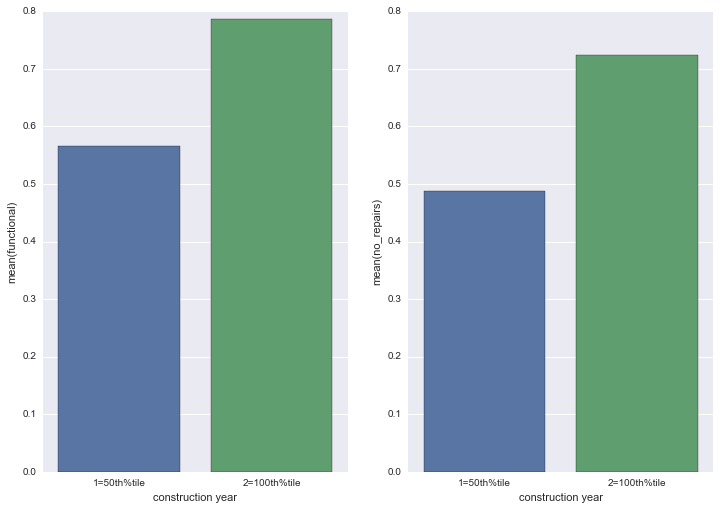

### Population

Contingency table of observed counts

populationgrp4,1=50th%tile,2=100th%tile
status_group,,
functional,7002,5700
functional needs repair,584,1019
non functional,3241,3563


populationgrp4,1=50th%tile,2=100th%tile
status_group,,
functional,0.646717,0.554367
functional needs repair,0.053939,0.099105
non functional,0.299344,0.346528


There is a significant relationship between population and the functional status of the waterpoint (p-value = 2.5e-13).

There is a significant relationship between population and the no repair status of the waterpoint (p-value = 1.2e-42).

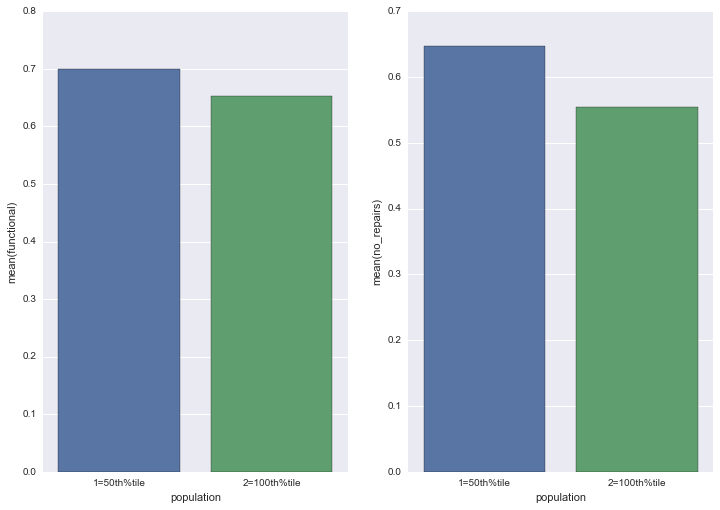

In [45]:
# for field in ('amount_tsh', 'gps_height', 'latitude', 'longitude', 'construction_year', 'population'):
for field in ('gps_height', 'latitude', 'longitude', 'construction_year', 'population'):
    field_name = ' '.join(field.split('_'))
    display_markdown("### {}".format(field_name.capitalize()), 
                     raw=True)
    var_analysis = clean_data[['status_group', 'functional', 'no_repairs']]
    clean_field = clean_data[field].map(lambda x: x if abs(x)>1e-8 else pd.np.nan)
    var_analysis = var_analysis.join(clean_field).dropna()
    
    var_analysis[field+'grp4'] = pd.qcut(var_analysis[field], 
                                         2,
                                         labels=["1=50th%tile", 
                                                 "2=100th%tile"])
#                                          4,
#                                          labels=["1=25th%tile", "2=50th%tile", 
#                                                  "3=75th%tile", "4=100th%tile"])
    
    # Chi-square test
    display_markdown("Contingency table of observed counts", raw=True)
    ct = pd.crosstab(var_analysis['status_group'], var_analysis[field+'grp4'])
    display(ct)
    ct_norm = ct/ct.sum(axis=0)
    display(ct_norm)

    ct = pd.crosstab(var_analysis['functional'], var_analysis[field+'grp4'])
    chisqr = stats.chi2_contingency(ct)

    if chisqr[1] > 0.05:
        display_markdown("There is *no* significant relationship between {} and the functional"
                         " status of the waterpoint (p-value = {:.2g}).".format(field_name, chisqr[1]),
                         raw=True)
    else:
        display_markdown("There is a significant relationship between {} and the functional"
                         " status of the waterpoint (p-value = {:.2g}).".format(field_name, chisqr[1]),
                         raw=True)

    ct = pd.crosstab(var_analysis['no_repairs'], var_analysis[field+'grp4'])
    chisqr = stats.chi2_contingency(ct)

    if chisqr[1] > 0.05:
        display_markdown("There is *no* significant relationship between {} and the no repair"
                         " status of the waterpoint (p-value = {:.2g}).".format(field_name, chisqr[1]),
                         raw=True)
    else:
        display_markdown("There is a significant relationship between {} and the no repair"
                         " status of the waterpoint (p-value = {:.2g}).".format(field_name, chisqr[1]),
                         raw=True)
        
    fig = plt.figure(figsize=[1.5*l for l in plt.rcParams['figure.figsize']])
    ax = fig.add_subplot(121)
    ax = sns.barplot(x=field+'grp4', y='functional', data=var_analysis, ci=None, ax=ax)
    ax.set_xlabel(field_name)
    ax = fig.add_subplot(122)
    ax = sns.barplot(x=field+'grp4', 
                     y='no_repairs', 
#                      data=var_analysis.where(var_analysis['functional'] == 1),
                     data=var_analysis,
                     ci=None,
                     ax=ax)
    ax.set_xlabel(field_name)
    plt.show()

In [30]:
# fit an Extra Trees model to the data and look at the first 20 important fields
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(predictors, deployed_data['status_group'])
# display the relative importance of each attribute
cm = sns.light_palette("yellow", as_cmap=True)
(pd.Series(model.feature_importances_, index=predictors.columns, name='importance')
   .sort_values(ascending=False)
   .to_frame()
   .iloc[:20]
   .style.background_gradient(cmap=cm))

In [40]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=25)
model = model.fit(predictors, deployed_data['status_group'])

In [41]:
clean_test_data = process_data.iloc[test_data.index].dropna()
predictions = model.predict(process_data.iloc[test_data.index].dropna())

In [42]:
pred = pd.Series(predictions, index=clean_test_data.index, name='status_group')

missing_index = list()
for i in test_data.index:
    if i not in clean_test_data.index:
        missing_index.append(i)

data_list = list()
pd.np.random.seed(12345)
for rnd in pd.np.random.rand(len(missing_index)):
    if rnd < 0.072677:
        data_list.append('functional needs repair')
    elif rnd < 0.384242 + 0.072677:
        data_list.append('non functional')
    else:
        data_list.append('functional')
fill = pd.Series(data_list, index=missing_index)

pred = pred.append(fill)
to_file = pred[test_data.index]
to_file.to_csv('randomForest.csv', index_label='id', header=('status_group',))

In [33]:
len(missing_index)

1194